# Python Learn by Doing: ENSO, Your Turn! Option 1 Answer Key

**Developed By:** Dr. Kerrie Geil, Mississippi State University

**Original Development Date:** June 2024

**Package Requirements:** xarray, netcdf4, numpy, pandas, scipy, matplotlib, jupyter, geopandas

**Links:** **[OSF project link](https://osf.io/zhpd5/)**, [link to this notebook on github]()

---
**Assignment:**

Using a shapefile with country boundaries, show a table of which South American countries experience statistically significant anomalous temperature and precipitation over at least 50% of the country's area during strong El Nino and La Nina events.

&emsp;Hints:
- Use World_Countries_Generalized.shp for country boundaries and subset to South America
- Repeat the appropriate steps from science questions 1 and 3
- Use the country boundaries on your gridded results to quantify which countries experience anomalous T and PR at the 50% area threshold
- Format your results in a pandas dataframe. Sort the dataframe descending by percent area impacted by anomalous conditions.

# Import packages and define workspace

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as ss
import geopandas as gpd
import warnings
import os
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

In [7]:
# create a folder for data downloads
if not os.path.exists('../data/World_Countries'):
    os.makedirs('../data/World_Countries')

In [8]:
# filenames to save data to and download urls
base_filename='../data/World_Countries/World_Countries'

shpfile_info=  {'.cpg':'https://osf.io/5xrgc/download',
                '.dbf':'https://osf.io/3a6rp/download',
                '.prj':'https://osf.io/43mnp/download',
                '.shp':'https://osf.io/r4dez/download',
                '.shp.xml':'https://osf.io/s4cvy/download',
                '.shx':'https://osf.io/kp6cm/download'}

# files we've already downloaded
nino_f = '../data/nino34_anomalies_monthly_NOAA.txt'
t_f = '../data/tavg_monthly_BerkeleyEarth.nc'
pr_f = '../data/precip_monthly_PRECL_NOAA.nc'

# Obtaining the data

We'll use a shapefile of country boundaries called [World Countries, originally obtained from ESRI ArcGIS Hub](https://hub.arcgis.com/datasets/esri::world-countries/explore) in June 2024 and copied to the [enso component of the MSU_py_training OSF project](https://osf.io/e726y/). 

<br>
<font color="green"><b>
**NOTE: You only need to run the following urlretrieve cell once. The data files will then be located on your computer. Files total approximately 130MB in size.**
</b></font> 

In [9]:
# download shapefile

for ext,url in shpfile_info.items():
    filename=base_filename+ext
    print('downloading',filename)
    urlretrieve(url,filename) # download and save data

downloading ../data/World_Countries/World_Countries.cpg
downloading ../data/World_Countries/World_Countries.dbf
downloading ../data/World_Countries/World_Countries.prj
downloading ../data/World_Countries/World_Countries.shp
downloading ../data/World_Countries/World_Countries.shp.xml
downloading ../data/World_Countries/World_Countries.shx


# Data Cleaning

We'll copy over the data cleaning steps from the enso_analysis.ipynb as well as subset global country boundaries to South American countries 

In [32]:
# data cleaning copied from enso_analysis.ipynb

year_start = '1948'
year_end = '2023'
base_start = '1981'
base_end = '2010'

dates=pd.date_range('1870-01-01','2024-12-01',freq='MS')

In [33]:
# data cleaning copied from enso_analysis.ipynb

# Nino 3.4 data
nino_raw=pd.read_csv(nino_f,sep=r'\s+',skiprows=1,skipfooter=7,header=None,index_col=0,na_values=-99.99,engine='python')
nino=nino_raw.to_numpy().flatten() 
nino=xr.DataArray(nino,name='nino',dims='time',coords={'time':dates}) 
nino.attrs['standard_name']='nino3.4 index'
nino.attrs['units']='C'
nino=nino.sel(time=slice(year_start,year_end))

In [34]:
# data cleaning copied from enso_analysis.ipynb

# precipitation data
ds=xr.open_dataset(pr_f)
pr=ds.precip
pr=pr.sel(time=slice(year_start,year_end)) 
pr=pr.reindex(lat=pr.lat[::-1]) 
pr.coords['lon']=xr.where(pr.coords['lon']>180,pr.coords['lon']-360,pr.coords['lon'])
roll_len=len(pr.lon)//2
pr=pr.roll(lon=roll_len,roll_coords=True)
pr_base=pr.sel(time=slice(base_start,base_end)) 
pr_clim=pr_base.groupby(pr_base.time.dt.month).mean('time') 
pr_anom=pr.groupby(pr.time.dt.month) - pr_clim  
pr_anom.attrs['standard_name']='pr anomaly'
pr_anom.attrs['units']='mm/day'

In [35]:
# data cleaning copied from enso_analysis.ipynb

# temperature data
ds=xr.open_dataset(t_f)
dates=pd.date_range('1750-01-01','2024-03-01',freq='MS')
ds['time']=dates
ds=ds.rename({'month_number':'month','latitude':'lat','longitude':'lon'})
t_anom_5180=ds.temperature
clim_5180=ds.climatology
t=t_anom_5180.groupby(t_anom_5180.time.dt.month)+clim_5180
t_base=t.sel(time=slice(base_start,base_end))  # subset in time
clim_8110 = t_base.groupby(t_base.time.dt.month).mean('time')  # long term means for each month
t_anom=t.groupby(t.time.dt.month)-clim_8110
t_anom=t_anom.sel(time=slice(year_start,year_end))
t_anom=t_anom.rename('tavg')
t_anom.attrs['standard_name']='T anomaly'
t_anom.attrs['units']='C'

In [36]:
# data cleaning copied from enso_analysis.ipynb

# check first and last time is the same for all data
variables=[nino, pr_anom, t_anom] # list of arrays
for var in variables:
    print(var.name, var.time[0].data,var.time[-1].data)

nino 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000
precip 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000
tavg 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000


In [40]:
# data cleaning copied from enso_analysis.ipynb

del ds, nino_raw, pr, pr_base, pr_clim,  t, t_anom_5180, t_base

In [37]:
# load shapefile of global country boundaries
countries=gpd.read_file(base_filename+'.shp')
countries

,COUNTRY,ISO_CC,CONTINENT,LAND_TYPE,LAND_RANK,COUNTRYAFF,geometry
0,Afghanistan,AFG,Asia,Primary land,5,Afghanistan,"POLYGON ((7903664.312 4647353.724, 7904616.405..."
1,Albania,ALB,Europe,Primary land,5,Albania,"POLYGON ((2198549.632 5255559.625, 2198549.632..."
2,Albania,ALB,Europe,Very small island,1,Albania,"MULTIPOLYGON (((2225504.394 4833346.591, 22255..."
3,Albania,ALB,Europe,Small island,2,Albania,"MULTIPOLYGON (((2146282.762 4939350.329, 21465..."
4,Algeria,DZA,Africa,Small island,2,Algeria,"POLYGON ((-125686.175 4262793.127, -125721.541..."
...,...,...,...,...,...,...,...
646,Yemen,YEM,Asia,Very small island,1,Yemen,"MULTIPOLYGON (((5803828.604 1395645.899, 58035..."
647,Yemen,YEM,Asia,Small island,2,Yemen,"MULTIPOLYGON (((5931926.381 1360057.795, 59327..."
648,Yemen,YEM,Asia,Medium island,3,Yemen,"POLYGON ((5960626.667 1426907.772, 5961018.460..."
649,Zambia,ZMB,Africa,Primary land,5,Zambia,"POLYGON ((3461259.840 -964526.128, 3462999.220..."


In [38]:
# subset to south america
countries=countries.loc[countries['CONTINENT']=='South America'].reset_index(drop=True)
countries

,COUNTRY,ISO_CC,CONTINENT,LAND_TYPE,LAND_RANK,COUNTRYAFF,geometry
0,Argentina,ARG,South America,Primary land,5,Argentina,"MULTIPOLYGON (((-7598665.999 -6985130.245, -75..."
1,Argentina,ARG,South America,Very small island,1,Argentina,"MULTIPOLYGON (((-7407780.432 -7373709.020, -74..."
2,Argentina,ARG,South America,Small island,2,Argentina,"MULTIPOLYGON (((-7495695.701 -7342298.536, -74..."
3,Argentina,ARG,South America,Medium island,3,Argentina,"MULTIPOLYGON (((-7159079.064 -7310806.220, -71..."
4,Aruba,ABW,South America,Small island,2,Netherlands,"POLYGON ((-7790943.290 1409456.671, -7790545.3..."
5,Bolivia,BOL,South America,Primary land,5,"Bolivia, Plurinational State of","POLYGON ((-7276452.049 -1085932.833, -7275783...."
6,Bonaire,BES,South America,Small island,2,Netherlands,"MULTIPOLYGON (((-7602534.044 1362876.285, -760..."
7,Brazil,BRA,South America,Small island,2,Brazil,"MULTIPOLYGON (((-5795759.866 -3769617.827, -57..."
8,Brazil,BRA,South America,Very small island,1,Brazil,"MULTIPOLYGON (((-5803326.654 -3765985.399, -58..."
9,Brazil,BRA,South America,Primary land,5,Brazil,"MULTIPOLYGON (((-5332204.442 -2885567.144, -53..."


In [39]:
# count how many different countries and see their names
print(len(countries.COUNTRY.unique()))
countries.COUNTRY.unique()

18


array(['Argentina', 'Aruba', 'Bolivia', 'Bonaire', 'Brazil', 'Chile',
       'Colombia', 'Curacao', 'Ecuador', 'Falkland Islands',
       'French Guiana', 'Guyana', 'Paraguay', 'Peru', 'Suriname',
       'Trinidad and Tobago', 'Uruguay', 'Venezuela'], dtype=object)

# Begin Main Analysis

First, we need to know when El Nino and La Nina events occurred so we'll copy over code from question 1 in enso_analysis.ipynb (How many strong El Nino and La Nina events have occurred from 1948 to 2023?). We only need the code that creates the array `nino_events` 

In [42]:
# copied from question 1 in enso_analysis.ipynb

# constants based on our criteria
nmonths=5
event_thresh=0.6

# first calculate the 5-month rolling mean
nino_rollmean=nino.rolling(time=nmonths,center=True).mean()

# create an array to hold our results and initialize to nan
# this array is where we will fill values with +1,-1
nino_events=nino_rollmean.copy() 
nino_events[:]=np.nan

# now loop through months and fill +1, -1 for windows of 5 months that meet our criteria
for i,value in enumerate(nino_rollmean):
    # La Nina conditions
    if  value < -event_thresh:
        # possible La Nina conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(window < -event_thresh):
            nino_events[i:i+nmonths] = -1

    # El Nino conditions
    if  value > event_thresh:
        # possible El Nino conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(window > event_thresh):
            nino_events[i:i+nmonths]=1    

Next, we need to build our El Nino composite and determine statistical significance. We'll copy over the relevant code from question 3 in enso_analysis.ipynb

t nino and non-nino sample sizes: 44 184


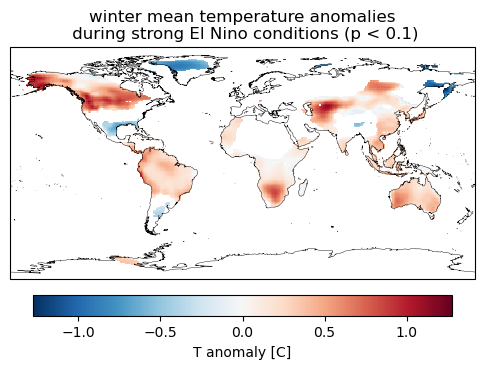

In [44]:
# copied from question 3 in enso_analysis.ipynb

# starting with el nino conditions, temperature
# get temperature anomalies only for times during strong el nino conditions
t_nino=t_anom.where(nino_events==1,drop=True)

# now separate out winter DJF months
# this is sample 1: winter months during strong el nino conditions
t_nino_DJF=t_nino.groupby(t_nino.time.dt.season)['DJF'] 

# make a composite
t_nino_DJF_composite=t_nino_DJF.mean('time',keep_attrs=True)

# create a t sample that include all winter months DJF when there are not strong el nino conditions

# all months that don't fall in strong nino events
t_other=t_anom.where(nino_events!=1,drop=True) 

# pull out just DJF months
# this is sample 2: all winter months that are NOT during strong el nino conditions
t_other_DJF=t_other.groupby(t_other.time.dt.season)['DJF'] 

print('t nino and non-nino sample sizes:',t_nino_DJF.shape[0],t_other_DJF.shape[0]) 

# t-test for difference in means 
t_sigtest = ss.ttest_ind(t_nino_DJF, t_other_DJF, axis=0, equal_var=False)
# numpy --> xarray
t_nino_pval = xr.DataArray(t_sigtest.pvalue, coords={'lat':('lat',t_nino.coords['lat'].data),'lon':('lon',t_nino.coords['lon'].data)})


# plot el nino temperature anomalies where statistically significant
pval=0.1

fig=plt.figure(figsize=(6,4))

ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nino_DJF_composite.where(t_nino_pval<pval).plot(cmap='RdBu_r',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'winter mean temperature anomalies\n during strong El Nino conditions (p < {pval})')

plt.show()


Now we can use our shapefile to answer the question: which South American countries experience statistically significant anomalous temperature and precipitation over at least 50% of the country's area during strong El Nino? 